In [1]:
import pickle
import pm4py
import pm4py.ocel
import random
from copy import copy
import torch_geometric as tg
import torch_geometric.utils as utils
from torch_geometric.data import HeteroData
from torch_geometric.datasets import FakeHeteroDataset
import torch
import logging
from torch import Tensor
from torch_geometric.typing import (
    DEFAULT_REL,
    EdgeTensorType,
    EdgeType,
    FeatureTensorType,
    NodeType,
    QueryType,
    SparseTensor,
)
from typing import Optional, Any, Callable
from pm4py.algo.transformation.ocel.features.objects import algorithm as object_feature_factory
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

ocel_file =  "../../data/BPI17/BPI2017-Final.jsonocel"

In [34]:
def get_index_map(df: pd.DataFrame, index_col_a: str, index_col_b: str) -> dict:
    return pd.Series(df[index_col_b].values, index=df[index_col_a]).to_dict()


def add_object_type_index(df: pd.DataFrame, object_type: str) -> pd.DataFrame:
    return (
        df.reset_index()
        .drop("index", axis=1)
        .reset_index()
        .rename(columns={"index": f"{object_type}_index"})
    )


def object_map_to_node_map(object_map: dict, node_map: dict, object_name: str) -> dict:
    return {
        k: node_map[v]
        for (k, v) in object_map.items()
        if object_name.lower() in k.lower()
    }


def split_on_edge_types(
    edge_list: list[tuple[str, str]], edge_types: list[tuple[str, str]]
) -> dict[tuple[str, str], list[tuple[str, str]]]:
    """
    Function that splits edges based on a given list of edge types.
    It returns a dict, with a key for each (found) edge type and a list for the corresponding edges.

    Currently, the function assumes directed edges. So do specify both ways, if undirected edges are wanted.

    Procedure:
    Per edge type (in edge_types), append all edges (from edge_list)
    if both the source and destination type of the edge corresponds to the edge type's source and destination
    """

    edges_split_on_type = dict()
    for edge_type in edge_types:
        for edge in edge_list:
            if edge_type[0] in edge[0].lower() and edge_type[1] in edge[1].lower():
                if edge_type in edges_split_on_type:
                    # if the key/edge_type already exists, append
                    edges_split_on_type[edge_type].append(edge)
                else:
                    # if this edge is the first of this edge_type
                    edges_split_on_type[edge_type] = [
                        edge
                    ]  # define a new key and value (list with the edge inside)
    return edges_split_on_type


def to_undirected(edge_list: list[tuple[str, str]]) -> list[tuple[str, str]]:
    return list(set(edge_list + [tuple(reversed(edge)) for edge in edge_list]))


def rename_edges(
    edges: list[tuple[Any, Any]],
    renaming_map: dict,
) -> list[tuple[Any, Any]]:
    renamed_edges = []
    for edge in edges:
        if edge[0] in renaming_map and edge[1] in renaming_map:
            renamed_edges.append((renaming_map[edge[0]], renaming_map[edge[1]]))
        elif edge[0] in renaming_map:
            renamed_edges.append((renaming_map[edge[0]], edge[1]))
        elif edge[1] in renaming_map:
            renamed_edges.append((edge[0], renaming_map[edge[1]]))
        else:
            renamed_edges.append(edge)
    return renamed_edges


def rename_edges_in_split_dict(
    split_edges: dict[tuple[str, str], list[tuple[Any, Any]]], renaming_map: dict
) -> dict[tuple[str, str], list[tuple[str, str]]]:
    return {
        edge_type: rename_edges(edges, renaming_map)
        for (edge_type, edges) in split_edges.items()
    }


In [3]:
ocel = pm4py.read.read_ocel(ocel_file)
ocel.objects.dtypes

ocel:oid                        object
ocel:type                       object
event_RequestedAmount          float64
event_LoanGoal                  object
event_ApplicationType           object
event_OfferedAmount            float64
event_NumberOfTerms            float64
event_CreditScore              float64
event_Accepted                  object
event_FirstWithdrawalAmount    float64
event_MonthlyCost              float64
event_Selected                  object
dtype: object

In [4]:
ocel.objects['event_Accepted'] = ocel.objects['event_Accepted'].replace({True: 1, False: 0})
ocel.objects['event_Selected'] = ocel.objects['event_Selected'].replace({True: 1, False: 0})
ocel.objects = ocel.objects.reset_index().rename(columns={'index':'object_index'})
ocel.objects.head()

,object_index,ocel:oid,ocel:type,event_RequestedAmount,event_LoanGoal,event_ApplicationType,event_OfferedAmount,event_NumberOfTerms,event_CreditScore,event_Accepted,event_FirstWithdrawalAmount,event_MonthlyCost,event_Selected
0,0,Application_652823628,application,20000.0,Existing loan takeover,New credit,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Offer_148581083,offer,NaN,NaN,NaN,20000.0,44.0,979.0,1.0,20000.0,498.29,1.0
2,2,Application_1691306052,application,10000.0,Home improvement,New credit,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Offer_1669071500,offer,NaN,NaN,NaN,6000.0,33.0,0.0,0.0,500.0,200.00,0.0
4,4,Application_428409768,application,15000.0,Home improvement,New credit,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
offer_attributes = {
    "str": [],
    "num": [
        "event_Accepted",
        "event_Selected",
        "event_OfferedAmount",
        "event_NumberOfTerms",
        "event_CreditScore",
        "event_FirstWithdrawalAmount",
        "event_MonthlyCost",
    ],
}
application_attributes = {
    "str": [
        "event_LoanGoal",
        "event_ApplicationType",
    ],
    "num": [
        "event_RequestedAmount",
    ],
}

In [6]:
data, feature_names = object_feature_factory.apply(
    ocel,
    parameters={
        "str_obj_attr": ["ocel:type"]
        + application_attributes["str"]
        + offer_attributes["str"],
        "num_obj_attr": ["object_index"]
        + application_attributes["num"]
        + offer_attributes["num"],
    },
)

In [7]:
object_features = pd.DataFrame(data, columns=feature_names)
oid_object_index_map = get_index_map(ocel.objects, "ocel:oid", "object_index")
# object_features.replace(oid_object_index_map)


In [8]:
object_features = object_features.rename(columns={'@@event_num_object_index':'object_index'})

object_features['object_index'] = object_features['object_index'].astype(int)
object_features['object_index'] = object_features['object_index'].replace(oid_object_index_map)

In [43]:



# Split object feature matrix into one feature matrix per object type
offer_features = object_features[
    object_features["@@object_attr_value_ocel:type_offer"] == 1
]
application_features = object_features[
    object_features["@@object_attr_value_ocel:type_application"] == 1
]

# Take only object attribute features, excluding object interaction features
flatten = lambda l: [item for sublist in l for item in sublist]
application_attribute_feature_idxs = flatten(
    [
        np.where(application_features.columns.str.contains(attr_name))[0]
        for attr_name in application_attributes["str"]
        + application_attributes["num"]
        + ["object_index"]
    ]
)
offer_attribute_feature_idxs = flatten(
    [
        np.where(offer_features.columns.str.contains(attr_name))[0]
        for attr_name in offer_attributes["str"] + offer_attributes["num"] + ["object_index"]
    ]
)
application_features = application_features.iloc[:, application_attribute_feature_idxs]
application_features = add_object_type_index(application_features, "application")
object_index_application_index_map = get_index_map(application_features, "object_index", "application_index")

offer_features = offer_features.iloc[:, offer_attribute_feature_idxs]
offer_features = add_object_type_index(offer_features, "offer")
object_index_offer_index_map = get_index_map(offer_features, "object_index", "offer_index")


In [44]:
application_features

,application_index,@@object_attr_value_event_LoanGoal_Caravan / Camper,@@object_attr_value_event_LoanGoal_Unknown,@@object_attr_value_event_LoanGoal_Remaining debt home,@@object_attr_value_event_LoanGoal_Car,@@object_attr_value_event_LoanGoal_Tax payments,@@object_attr_value_event_LoanGoal_Motorcycle,@@object_attr_value_event_LoanGoal_Debt restructuring,@@object_attr_value_event_LoanGoal_Home improvement,@@object_attr_value_event_LoanGoal_Boat,@@object_attr_value_event_LoanGoal_Business goal,@@object_attr_value_event_LoanGoal_Not speficied,@@object_attr_value_event_LoanGoal_Extra spending limit,@@object_attr_value_event_LoanGoal_Existing loan takeover,"@@object_attr_value_event_LoanGoal_Other, see explanation",@@object_attr_value_event_ApplicationType_Limit raise,@@object_attr_value_event_ApplicationType_New credit,@@event_num_event_RequestedAmount,object_index
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,20000.0,0
1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,10000.0,2
2,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,15000.0,4
3,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,5000.0,7
4,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,35000.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31504,31504,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,5000.0,74493
31505,31505,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,15000.0,74495
31506,31506,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,10000.0,74498
31507,31507,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,30000.0,74500


In [45]:
graph = pm4py.ocel.discover_objects_graph(ocel, graph_type="object_interaction")
with open('../../data/BPI17/ocpa-processed/object_interaction_graph.pkl','wb') as f:
    pickle.dump(graph, f)


In [46]:
bpi17_edge_types = [('offer','offer'), ('application','offer'), ('application','application')]
bpi17_edges_per_edge_type = split_on_edge_types(list(graph), bpi17_edge_types)
bpi17_edges_per_edge_type

{('offer', 'offer'): [('Offer_1705686948', 'Offer_969403262'),
  ('Offer_1494047016', 'Offer_97324334'),
  ('Offer_1775547872', 'Offer_1934126271'),
  ('Offer_1295524956', 'Offer_345746891'),
  ('Offer_648477210', 'Offer_650999237'),
  ('Offer_2048741098', 'Offer_535995624'),
  ('Offer_1456299880', 'Offer_1536300777'),
  ('Offer_278455731', 'Offer_788969230'),
  ('Offer_734883799', 'Offer_814034082'),
  ('Offer_116891326', 'Offer_1890270696'),
  ('Offer_2023101042', 'Offer_587535462'),
  ('Offer_1284560550', 'Offer_1982495450'),
  ('Offer_142934028', 'Offer_1909732934'),
  ('Offer_1981163425', 'Offer_371403489'),
  ('Offer_1772932150', 'Offer_257530325'),
  ('Offer_1311549031', 'Offer_200246929'),
  ('Offer_1095204279', 'Offer_307227580'),
  ('Offer_1002568994', 'Offer_1298138205'),
  ('Offer_1091287872', 'Offer_813558300'),
  ('Offer_1673725170', 'Offer_1774305786'),
  ('Offer_307226561', 'Offer_389361920'),
  ('Offer_1483261235', 'Offer_1619580585'),
  ('Offer_1255196803', 'Offer_998

In [47]:
application_to_node_map = object_map_to_node_map(oid_object_index_map, object_index_application_index_map, 'application')
offer_to_node_map = object_map_to_node_map(oid_object_index_map, object_index_offer_index_map, 'offer')

In [48]:
bpi17_edges_per_edge_type.keys()

dict_keys([('offer', 'offer'), ('application', 'offer')])

In [49]:
bpi17_edges_per_edge_type = rename_edges_in_split_dict(bpi17_edges_per_edge_type, application_to_node_map)
bpi17_edges_per_edge_type = rename_edges_in_split_dict(bpi17_edges_per_edge_type, offer_to_node_map)

bpi17_edges_per_edge_type

{('offer', 'offer'): [(8426, 8427),
  (19710, 19708),
  (17756, 17755),
  (15143, 15144),
  (35825, 35826),
  (10759, 10757),
  (19036, 19035),
  (1429, 1430),
  (38753, 38754),
  (2838, 2840),
  (3165, 3163),
  (102, 104),
  (2807, 2806),
  (42074, 42073),
  (963, 962),
  (26353, 26352),
  (3366, 3367),
  (7000, 7003),
  (39866, 39864),
  (13970, 13969),
  (40966, 40965),
  (1917, 1918),
  (26001, 26000),
  (3306, 3305),
  (19125, 19124),
  (30136, 30135),
  (13664, 13665),
  (42541, 42542),
  (8239, 8238),
  (9286, 9287),
  (1807, 1806),
  (23828, 23827),
  (34164, 34163),
  (7750, 7752),
  (26338, 26337),
  (16082, 16081),
  (13969, 13968),
  (17759, 17760),
  (22959, 22958),
  (2487, 2488),
  (38414, 38413),
  (41813, 41814),
  (19928, 19929),
  (20172, 20171),
  (4121, 4122),
  (20357, 20358),
  (4510, 4509),
  (1502, 1508),
  (29279, 29280),
  (27158, 27159),
  (20755, 20754),
  (18389, 18387),
  (43, 44),
  (2841, 2840),
  (14469, 14470),
  (38590, 38589),
  (10923, 10922),
  (7

In [ ]:
offer_fts_sample = torch.tensor(offer_features.iloc[:5, :-1].values)
application_fts_sample = torch.tensor(application_features.iloc[:5, :-1].values)
print('offer_fts_sample')
print(offer_fts_sample)
print('application_fts_sample')
print(application_fts_sample)

offer_fts_sample
tensor([[1.0000e+00, 1.0000e+00, 2.0000e+04, 4.4000e+01, 9.7900e+02, 2.0000e+04,
         4.9829e+02],
        [0.0000e+00, 0.0000e+00, 6.0000e+03, 3.3000e+01, 0.0000e+00, 5.0000e+02,
         2.0000e+02],
        [1.0000e+00, 0.0000e+00, 1.5000e+04, 1.2000e+02, 0.0000e+00, 1.5000e+04,
         1.5898e+02],
        [1.0000e+00, 1.0000e+00, 1.5000e+04, 1.2000e+02, 1.0590e+03, 1.5000e+04,
         1.5898e+02],
        [0.0000e+00, 1.0000e+00, 1.5700e+04, 7.2000e+01, 8.3400e+02, 3.7260e+03,
         2.5273e+02]], dtype=torch.float64)
application_fts_sample
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+04],
        [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+

In [51]:
hetero_data = HeteroData()
hetero_data["offer"].x = torch.tensor(offer_features.iloc[:, :-1].values)
hetero_data["application"].x = torch.tensor(application_features.iloc[:, :-1].values)
# hetero_data["application", "interacts with", "application"].edge_index = bpi17_edges_per_edge_type[('application','application')]
hetero_data["application", "interacts with", "offer"].edge_index = bpi17_edges_per_edge_type[('application','offer')]
hetero_data["offer", "interacts with", "offer"].edge_index = bpi17_edges_per_edge_type[('offer','offer')]
hetero_data

# TEST DE edge_index

HeteroData(
  offer={ x=[42995, 8] },
  application={ x=[31509, 18] },
  (application, interacts with, offer)={ edge_index=[42995] },
  (offer, interacts with, offer)={ edge_index=[6027] }
)

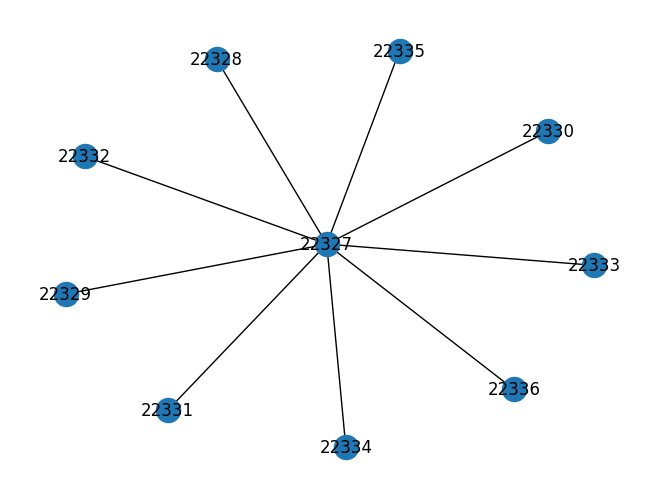

In [ ]:
G = nx.Graph()
G.add_edges_from(graph)
some_graph = {x for x in graph if 'Application_2114646933' in x }
sorted_cc = sorted(list(nx.connected_components(G)), key=len, reverse=True)
sg = G.subgraph(sorted_cc[4])
# sg = nx.Graph()
# sg.add_edges_from(some_graph_adjacency)
nx.draw(sg, with_labels = True)
plt.savefig("../../tests/objects_interaction_graph.png")

In [ ]:
from torch_geometric.datasets import OGB_MAG

dataset = OGB_MAG(root='./data', preprocess='metapath2vec')
citation_network = dataset[0]
citation_network

HeteroData(
  paper={
    x=[736389, 128],
    year=[736389],
    y=[736389],
    train_mask=[736389],
    val_mask=[736389],
    test_mask=[736389]
  },
  author={ x=[1134649, 128] },
  institution={ x=[8740, 128] },
  field_of_study={ x=[59965, 128] },
  (author, affiliated_with, institution)={ edge_index=[2, 1043998] },
  (author, writes, paper)={ edge_index=[2, 7145660] },
  (paper, cites, paper)={ edge_index=[2, 5416271] },
  (paper, has_topic, field_of_study)={ edge_index=[2, 7505078] }
)

In [ ]:
example_edge = citation_network.edge_items()[0]
edge_tensor = example_edge[1].edge_index

In [ ]:
edge_tensor.shape

torch.Size([2, 1043998])

In [ ]:
# testing to check whether we can indicate correct nodes from each node type in the edge_index
orders = {"price": [1250, 678], "discount": [33, 0], "black_friday_sale":[1, 0]}
items = {"weight": [3.5, 3.0, 26.0], "size": [2, 2, 3]}
order_x_tensor = torch.tensor(list(orders.values()))[1:].T
order_y_tensor = torch.tensor(list(orders.values()))[0].T # order_price will be the target
item_x_tensor = torch.tensor(list(items.values())).T
o_o_interaction = torch.tensor([[],[]])
o_i_interaction = torch.tensor([[0,0,2, 2,3,3],[2,3,3, 0,0,2]])
i_i_interaction = torch.tensor([[3, 4],[4, 3]])
test_het = HeteroData({'order': {'x': order_x_tensor, 'y': order_y_tensor}, 'item': {'x': item_x_tensor}}, 
                  order__interacts_with__order={'edge_index': o_o_interaction}, 
                  order__interacts_with__item={'edge_index': o_i_interaction}, 
                  item__interacts_with__item={'edge_index': i_i_interaction})

C:\Users\Tim\AppData\Local\Temp\ipykernel_7096\738230436.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3575.)
  order_y_tensor = torch.tensor(list(orders.values()))[0].T # order_price will be the target


In [ ]:
test_het = HeteroData({'order': {'x': order_x_tensor, 'y': order_y_tensor}, 'item': {'x': item_x_tensor}}, 
                  order__interacts_with__order={'edge_index': o_o_interaction}, 
                  order__interacts_with__item={'edge_index': o_i_interaction}, 
                  item__interacts_with__item={'edge_index': i_i_interaction})

In [ ]:
def get_node_slices(num_nodes: dict[str, int]) -> dict[str, tuple[int, int]]:
    r"""Returns the boundaries of each node type in a graph."""
    node_slices: dict[NodeType, tuple[int, int]] = {}
    cumsum = 0
    for node_type, N in num_nodes.items():
        node_slices[node_type] = (cumsum, cumsum + N)
        cumsum += N
    return node_slices

def offset_edge_index(
    node_slices: dict[NodeType, tuple[int, int]],
    edge_type: EdgeType,
    edge_index: Tensor,
) -> Tensor:
    r"""Increases the edge indices by the offsets of source and destination
    node types."""
    src, _, dst = edge_type
    offset = [[node_slices[src][0]], [node_slices[dst][0]]]
    offset = torch.tensor(offset, device=edge_index.device)
    return edge_index + offset

def to_homogeneous_edge_index(
    data: HeteroData,
) -> tuple[Optional[Tensor], dict[NodeType, Any], dict[EdgeType, Any]]:
    r"""Converts a heterogeneous graph into a homogeneous typed graph."""
    # Record slice information per node type:
    node_slices = get_node_slices(data.num_nodes_dict)

    # Record edge indices and slice information per edge type:
    cumsum = 0
    edge_indices: list[Tensor] = []
    edge_slices: dict[EdgeType, tuple[int, int]] = {}
    for edge_type, edge_index in data.edge_index_dict.items():
        edge_index = offset_edge_index(node_slices, edge_type, edge_index)
        edge_indices.append(edge_index)
        edge_slices[edge_type] = (cumsum, cumsum + edge_index.size(1))
        cumsum += edge_index.size(1)

    edge_index: Optional[Tensor] = None
    if len(edge_indices) == 1:  # Memory-efficient `torch.cat`:
        edge_index = edge_indices[0]
    elif len(edge_indices) > 1:
        edge_index = torch.cat(edge_indices, dim=-1)

    return edge_index, node_slices, edge_slices


HeteroData(
  order={
    x=[2, 2],
    y=[2]
  },
  v0={ x=[3, 2] },
  (order, interacts_with, order)={ edge_index=[2, 0] },
  (order, interacts_with, item)={ edge_index=[2, 6] },
  (item, interacts_with, item)={ edge_index=[2, 2] }
)

In [ ]:
fake_het = FakeHeteroDataset(
    num_node_types=2, num_edge_types=3, avg_num_nodes=2.5, num_classes=2, avg_degree=1, avg_num_channels=3
)
fake_het = fake_het[0]
# fake_het.generate_ids()
fake_het

HeteroData(
  v0={
    x=[3, 2],
    y=[3]
  },
  v1={ x=[2, 3] },
  (v1, e0, v1)={ edge_index=[2, 2] },
  (v0, e0, v0)={ edge_index=[2, 3] },
  (v0, e0, v1)={ edge_index=[2, 3] }
)

In [ ]:
fake_het['v0']

{'x': tensor([[ 3.3094,  0.6268],
        [-0.2359,  0.8320]]), 'y': tensor([0, 1]), 'n_id': tensor([0, 1])}

In [ ]:
fake_het
fake_het.to_dict()

{'v0': {'x': tensor([[ 1.8118, -0.1588],
          [ 1.5171, -0.1776],
          [-1.6878,  0.9682]]),
  'y': tensor([0, 0, 0])},
 'v1': {'x': tensor([[-1.4118,  0.6501,  0.7804],
          [-1.1167, -0.4722,  1.4561]])},
 ('v1',
  'e0',
  'v1'): {'edge_index': tensor([[0, 0],
          [0, 1]])},
 ('v0',
  'e0',
  'v0'): {'edge_index': tensor([[1, 1, 2],
          [0, 1, 2]])},
 ('v0',
  'e0',
  'v1'): {'edge_index': tensor([[1, 2, 2],
          [0, 0, 1]])}}

In [ ]:
fake_het['(v1, e0, v1)']

{}

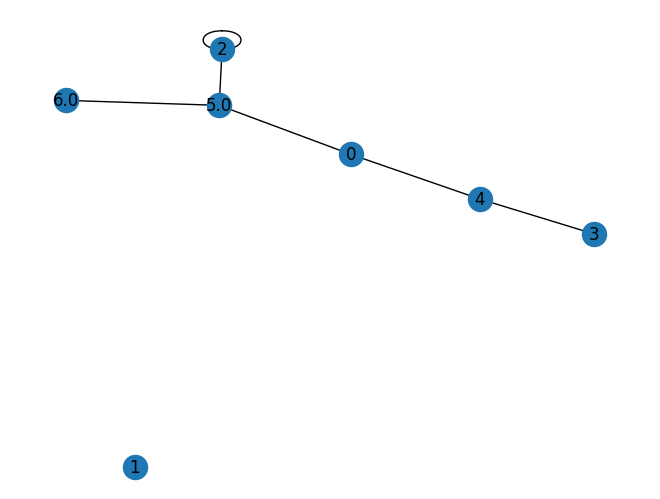

In [ ]:
g = utils.to_networkx(test_het.to_homogeneous(), to_undirected=True)
nx.draw(g, with_labels=True)

In [ ]:
# define a format for the adjacency matrix (use real oid or custom object_index?)

In [ ]:
# Define HeteroData in PyG, using offer_features, application_features, and the adjacency matrix

In [ ]:
# build OFG class that can hold features
# enable this class to be ported to PyG


In [ ]:
# COULD MOVE THIS TO A UNIT TEST FILE
# example_edges = [('o1','i1'),('o1','i2'),('i2','i3'),('i3','o2')]
# test_split = split_on_edge_types(edge_list=to_undirected(example_edges), edge_types=[('o','i'), ('i','i')])
# test_split